# Autoencoder-Based Anomaly Detection System for File Classification approach (on mfcc)

In [ ]:
import gdown

In [ ]:
file_id = "1DvGEQbasZWCm4PRiPWNDcEsDBW-K6f21"
gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output="data.zip", quiet=False)




Downloading...
From: https://drive.google.com/uc?id=1DvGEQbasZWCm4PRiPWNDcEsDBW-K6f21&confirm=t
To: /content/data.zip
100%|██████████| 10.4G/10.4G [02:31<00:00, 68.8MB/s]


'data.zip'

In [ ]:
!unzip data.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/fan/id_00/normal/00000152.wav  
  inflating: data/fan/id_00/normal/00000153.wav  
  inflating: data/fan/id_00/normal/00000154.wav  
  inflating: data/fan/id_00/normal/00000155.wav  
  inflating: data/fan/id_00/normal/00000156.wav  
  inflating: data/fan/id_00/normal/00000157.wav  
  inflating: data/fan/id_00/normal/00000158.wav  
  inflating: data/fan/id_00/normal/00000159.wav  
  inflating: data/fan/id_00/normal/00000160.wav  
  inflating: data/fan/id_00/normal/00000161.wav  
  inflating: data/fan/id_00/normal/00000162.wav  
  inflating: data/fan/id_00/normal/00000163.wav  
  inflating: data/fan/id_00/normal/00000164.wav  
  inflating: data/fan/id_00/normal/00000165.wav  
  inflating: data/fan/id_00/normal/00000166.wav  
  inflating: data/fan/id_00/normal/00000167.wav  
  inflating: data/fan/id_00/normal/00000168.wav  
  inflating: data/fan/id_00/normal/00000169.wav  
  inflating: data/fan/

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchaudio
import numpy as np
import random
import os
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using Device: {device}")


 Using Device: cuda


In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
import os
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset

class MFCCDataset(Dataset):
    def __init__(self, file_paths, labels, sr=16000, n_mfcc=40, max_len=200):
        """
        file_paths: list of .wav file paths
        labels: list of integers (0 = normal, 1 = abnormal)
        """
        self.file_paths = file_paths
        self.labels = labels
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.max_len = max_len

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load audio (mono)
        audio, _ = librosa.load(file_path, sr=self.sr, mono=True)

        # Compute MFCC
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=self.sr,
            n_mfcc=self.n_mfcc
        )

        # Normalize
        mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)

        # Pad / truncate
        if mfcc.shape[1] < self.max_len:
            pad_len = self.max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_len)), mode="constant")
        else:
            mfcc = mfcc[:, :self.max_len]

        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(label, dtype=torch.long)



In [ ]:
print("Searching for files...")
all_files = []
labels = []

for root, dirs, files in os.walk("/content"):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            all_files.append(path)

            # Detect anomaly
            if "abnormal" in root.lower() or "anomalous" in root.lower():
                labels.append(1)
            else:
                labels.append(0)
    from sklearn.model_selection import train_test_split




Searching for files...


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    all_files, labels, test_size=0.2,
    stratify=labels, random_state=42
)

In [ ]:
train_ds = MFCCDataset(X_train, y_train)
val_ds   = MFCCDataset(X_val, y_val)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"Data Ready. Train: {len(train_ds)}, Val: {len(val_ds)}")


Data Ready. Train: 4440, Val: 1110


In [ ]:
#simple classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=400*40): # Time * MFCC features
        super(SimpleClassifier, self).__init__()

        # 1. The "Encoder" part (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3), # Helps prevent overfitting

            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 64), # Latent representation
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        # 2. The "Classifier" Head
        self.classifier = nn.Linear(64, 2) # Output: [Logits for Class 0, Logits for Class 1]

    def forward(self, x):
        # Flatten: [Batch, 400, 40] -> [Batch, 16000]
        batch_size = x.size(0)
        x = x.view(batch_size, -1)

        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

In [ ]:
# Initialize Model
model = SimpleClassifier().to(device)
print(model)
print(" Custom Transformer Created!")

SimpleClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=16000, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)
 Custom Transformer Created!


In [ ]:
! pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.7 MB/s eta 0:00:00


In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()

    total_loss = 0
    correct = 0
    total = 0

    for mfccs, labels in tqdm(train_loader, desc="Training"):
        mfccs, labels = mfccs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(mfccs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(train_loader)

    return avg_loss, accuracy


In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for mfccs, labels in tqdm(val_loader, desc="Validating"):
            mfccs, labels = mfccs.to(device), labels.to(device)

            outputs = model(mfccs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)

    return avg_loss, accuracy


In [ ]:
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, device="cuda"):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        print(f"\n----- Epoch {epoch+1}/{epochs} -----")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    return history


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
# initialize the model with the  input_dim
# The MFCCDataset in use (from cell EeGgw8nfkevf) has max_len=200 and n_mfcc=40,
# so the flattened input dimension is 200 * 40 = 8000.
model = SimpleClassifier(input_dim=200*40).to(device)

history = train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, device=device)


----- Epoch 1/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.2781 | Train Acc: 88.76%
Val Loss:   0.4799 | Val Acc:   81.80%

----- Epoch 2/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.1177 | Train Acc: 95.81%
Val Loss:   0.1392 | Val Acc:   94.59%

----- Epoch 3/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0877 | Train Acc: 96.78%
Val Loss:   0.1085 | Val Acc:   95.59%

----- Epoch 4/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0778 | Train Acc: 97.07%
Val Loss:   0.4904 | Val Acc:   87.93%

----- Epoch 5/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0581 | Train Acc: 97.95%
Val Loss:   0.1816 | Val Acc:   93.33%

----- Epoch 6/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0499 | Train Acc: 98.15%
Val Loss:   0.1324 | Val Acc:   94.95%

----- Epoch 7/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0344 | Train Acc: 98.85%
Val Loss:   0.9778 | Val Acc:   68.38%

----- Epoch 8/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0485 | Train Acc: 98.45%
Val Loss:   0.2837 | Val Acc:   90.09%

----- Epoch 9/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0380 | Train Acc: 98.69%
Val Loss:   0.1175 | Val Acc:   96.04%

----- Epoch 10/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0247 | Train Acc: 99.08%
Val Loss:   0.1618 | Val Acc:   94.50%

----- Epoch 11/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0325 | Train Acc: 98.76%
Val Loss:   0.5683 | Val Acc:   86.49%

----- Epoch 12/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0260 | Train Acc: 99.10%
Val Loss:   0.2911 | Val Acc:   90.27%

----- Epoch 13/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0167 | Train Acc: 99.39%
Val Loss:   0.0907 | Val Acc:   97.30%

----- Epoch 14/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0366 | Train Acc: 98.85%
Val Loss:   0.8374 | Val Acc:   73.42%

----- Epoch 15/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0244 | Train Acc: 99.26%
Val Loss:   0.5225 | Val Acc:   90.36%

----- Epoch 16/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0103 | Train Acc: 99.71%
Val Loss:   0.0870 | Val Acc:   97.48%

----- Epoch 17/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0232 | Train Acc: 99.05%
Val Loss:   0.0777 | Val Acc:   97.57%

----- Epoch 18/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0122 | Train Acc: 99.66%
Val Loss:   0.0663 | Val Acc:   98.29%

----- Epoch 19/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0363 | Train Acc: 98.65%
Val Loss:   0.3044 | Val Acc:   90.00%

----- Epoch 20/20 -----


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 0.0177 | Train Acc: 99.44%
Val Loss:   0.0876 | Val Acc:   98.11%


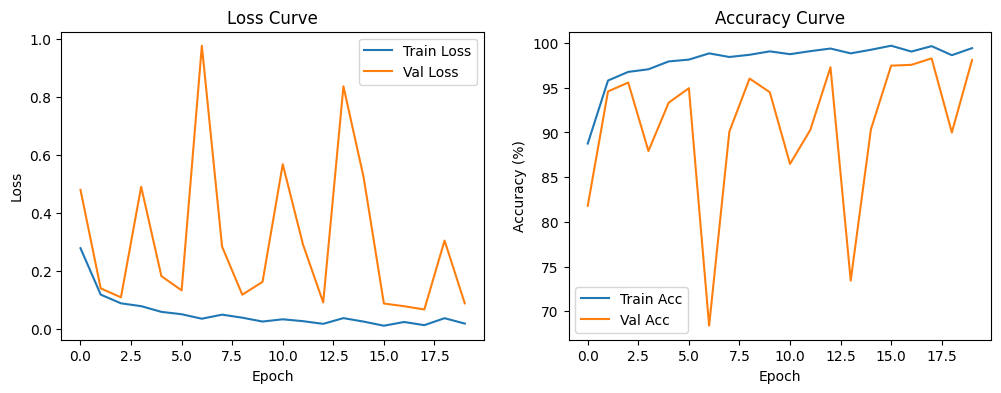

In [ ]:
plot_history(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval() # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for mfccs, labels in val_loader:
        mfccs, labels = mfccs.to(device), labels.to(device)
        outputs = model(mfccs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Abnormal"]))


--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       815
    Abnormal       0.98      0.95      0.96       295

    accuracy                           0.98      1110
   macro avg       0.98      0.97      0.98      1110
weighted avg       0.98      0.98      0.98      1110



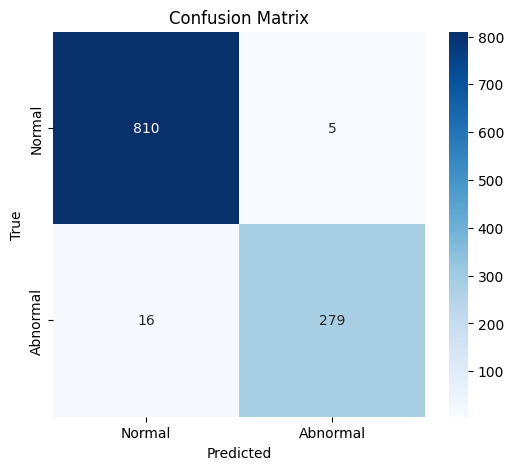

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import librosa
import numpy as np
import torch
import random

# Get a random file and its actual label from the validation set
random_idx = random.randint(0, len(X_val) - 1)
random_audio_path = X_val[random_idx]
actual_label_int = y_val[random_idx]
actual_label = "Abnormal" if actual_label_int == 1 else "Normal"

print(f"Testing random file: {random_audio_path}")
print(f"Actual label: {actual_label}")

# --- Preprocessing steps (copied from MFCCDataset and predict_audio) ---
sr = 16000
n_mfcc = 40
max_len = 200

# 1. Load Audio (using librosa)
audio, _ = librosa.load(random_audio_path, sr=sr, mono=True)

# 2. Compute MFCC (using librosa)
mfcc = librosa.feature.mfcc(
    y=audio,
    sr=sr,
    n_mfcc=n_mfcc
)

# Normalize
mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)

# Pad / truncate
if mfcc.shape[1] < max_len:
    pad_len = max_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, ((0, 0), (0, pad_len)), mode="constant")
else:
    mfcc = mfcc[:, :max_len]

# Convert to PyTorch tensor and add batch dimension
mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)

# --- Model Prediction ---
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(mfcc_tensor)
    _, predicted = torch.max(outputs, 1)

predicted_label = "Abnormal" if predicted.item() == 1 else "Normal"
print(f"Predicted label: {predicted_label}")

Testing random file: /content/data/fan/id_00/abnormal/00000370.wav
Actual label: Abnormal
Predicted label: Abnormal


In [ ]:
import librosa
import numpy as np
import torch
from IPython.display import Audio, display

def analyze_audio_file(audio_path, model, device, sr=16000, n_mfcc=40, max_len=200):
    print(f"Analyzing audio file: {audio_path}")

    # Play the audio
    print("Playing audio...")
    display(Audio(audio_path, rate=sr))

    # --- Preprocessing steps (consistent with MFCCDataset) ---
    model.eval() # Set the model to evaluation mode

    # 1. Load Audio (using librosa)
    audio, _ = librosa.load(audio_path, sr=sr, mono=True)

    # 2. Compute MFCC (using librosa)
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc
    )

    # Normalize
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)

    # Pad / truncate
    if mfcc.shape[1] < max_len:
        pad_len = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_len)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    # Convert to PyTorch tensor and add batch dimension
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)

    # --- Model Prediction ---
    with torch.no_grad():
        outputs = model(mfcc_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_label = "Abnormal" if predicted.item() == 1 else "Normal"
    print(f"Prediction: {predicted_label}")
    return predicted_label

In [ ]:
# Example usage:
random_idx = random.randint(0, len(X_val) - 1)
random_audio_path = X_val[random_idx]
actual_label = "Abnormal" if y_val[random_idx] == 1 else "Normal"

print(f"Actual label for this file: {actual_label}")
analyze_audio_file(random_audio_path, model, device)

Actual label for this file: Normal
Analyzing audio file: /content/data/fan/id_02/normal/00000533.wav
Playing audio...


Prediction: Normal


'Normal'

In [ ]:
path='/content/data/fan/id_00/abnormal/00000396.wav'
actual_label='abnormal'
analyze_audio_file(path, model, device)

Analyzing audio file: /content/data/fan/id_00/abnormal/00000396.wav
Playing audio...


Prediction: Abnormal


'Abnormal'

In [ ]:
path='/content/data/fan/id_06/normal/00000001.wav'
actual_label='normal'
analyze_audio_file(path, model, device)

Analyzing audio file: /content/data/fan/id_06/normal/00000001.wav
Playing audio...


In [ ]:
#saving model in git